# Simulation of galactic sources

In [1]:
import simulation ##This function draws sources from spatial distribution with luminosity 1-100GeV
import numpy as np
import makemap
import matplotlib as mpl
c6 = '#e41a1c'
c2 = '#377eb8'
c3 = '#4daf4a'
c4 = '#984ea3'
c5 = '#ff7f00'
c1 = '#66c2a5'
c7 = '#a65628'
c8 = '#f781bf'
c9 = '#999999'
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
from matplotlib import gridspec
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text',usetex=True)
import pylab as plt
%matplotlib inline

/home/mart/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [19]:
##Setup some arrays for later

Ebins = np.logspace(0,3,101)
dE = (Ebins[1:]-Ebins[0:-1])
Emean = (Ebins[1:]+Ebins[0:-1])/2.
E3fgl = np.logspace(0,2,101)
E3fgl_mean = (E3fgl[1:]+E3fgl[:-1])/2.
mask_E3FGL = (Emean>=1)&(Emean<100)
bins_3fgl = np.logspace(-14,-6,32)
bins_3fgl_mean = (bins_3fgl[1:]+bins_3fgl[0:-1])/2.
bins_3fhl = np.logspace(-16,-8,32)
bins_3fhl_mean = (bins_3fhl[1:]+bins_3fhl[0:-1])/2.


## Read 3FGL catalog

In [20]:
##Read 3FGL galactic sources
fl = 'gll_psc_v16.fit'

flux_3fgl,spec_3fgl = simulation.read_catalog(fl,E3fgl_mean,classes=['pwn','spp','snr','psr','lat'])
##'lat' means take also unassociated sources with |b|<5
hist_3fgl = np.histogram(flux_3fgl,bins=bins_3fgl)[0]

## Spectrum of 3FGL (galactic sources)

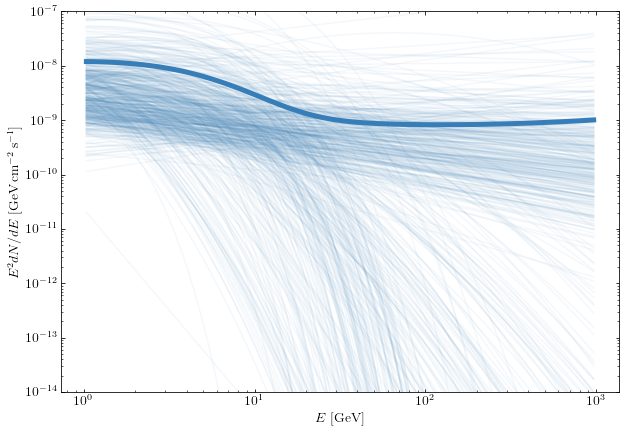

In [4]:
f,ax = plt.subplots(1,figsize=(10,7))
for sp in spec_3fgl:
    ax.loglog(Emean,Emean**2*sp,color=c2,alpha=0.05,zorder=1)

ax.loglog(Emean,Emean**2*np.mean(spec_3fgl,axis=0),color=c2,alpha=1,lw=5,zorder=10)
ax.set_ylim([1e-14,1e-7])
ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
#ax.get_yaxis().set_ticks([])
ax.set_ylabel(r"$E^2 dN/dE$  $\rm [GeV\,cm^{-2} \, s^{-1}]$",fontsize=14)
ax.set_xlabel(r"$E$ [GeV]",fontsize=14)
plt.legend(frameon=False,fontsize=14,loc=1)

## Load the diffuse pion emission as measured with SkyFACT

In [44]:
###Diffuse pion

###Load diffuse flux from skyfact fit
###Here load the diffuse flux at different l,b. To plot some fractions later.

import open_dat
from scipy.optimize import curve_fit

##These longitudes and latitude cuts
lb = [(180,20),(180,1),(20,20),(20,1)]

modelfunc = lambda x,p1,p2: p1-p2*x
model27 = lambda x,p: p-2.7*x  
plotfunc = lambda E,a,b: b*(E)**-a

def get_diffuse(E):

    spec_diff_lb = []

    ##At different lb
    for ilb in lb:
        datfile = open_dat.open_dat('spec_ll_bb/r5_fulldisk_combine_l%s_b%s.dat'%ilb)
        spec,E_diff,error = simulation.read_datfile(datfile)
        mask_E_diff = E_diff > 2
        E_diff = E_diff[mask_E_diff]
        spec = spec[mask_E_diff]
        err = error[mask_E_diff]

        fit,cov = curve_fit(modelfunc,np.log10(E_diff),np.log10(spec),p0=[-7,2.7],sigma=err/spec)
        fitted_spec = plotfunc(Emean,fit[1],10**fit[0]) ##If this is a softer spectra this matters a lot!
        fit27,cov27 = curve_fit(model27,np.log10(E_diff),np.log10(spec),p0=[-7],sigma=err/spec)

        ####This matters a lot!
        diff_index = fit[1]
        fitted_spec = plotfunc(E,diff_index,10**fit[0]) ##If this is a softer spectra this matters a lot!

        spec_diff_lb.append(fitted_spec)
    return spec_diff_lb
    
spec_diff_lb_3fgl = get_diffuse(E3fgl_mean)

## Function to sample galaxy and calculate things we want to know
Namely: fraction of flux from unresolved sources, latitude,longitude profiles and histogram of flux

In [145]:
def fraction(N,a,Lmin,Lmax,thres,Eb,spec,spec_diff_lb,bins):
    Emean = (Eb[1:]+Eb[0:-1])/2.
    dE = (Eb[1:]-Eb[0:-1])
    spec_sim,flux_sim,lb_sim = simulation.source_sim(N,a,Lmin,Lmax,spec,Emean,dE,thres)
    l_sim = lb_sim[0,:]
    b_sim = lb_sim[1,:]
    fluxmask = flux_sim < thres
    flux_unres = flux_sim[fluxmask]
    l_unres = l_sim[fluxmask]
    b_unres = b_sim[fluxmask]
    frac_lb = []
#     for sp in spec_sim[fluxmask][::100]:
#         plt.loglog(Emean,Emean**2*sp,alpha=0.3)
#     plt.ylim([1e-13,1e-8])
#     plt.loglog(Emean,Emean**2*np.mean(spec_sim[fluxmask],axis=0),color='black',lw=5)
    for ilb,_lb in enumerate(lb):
        diff_lb = spec_diff_lb[ilb]
        lmask = l_sim<=_lb[0]
        bmask = b_sim<=_lb[1]
        totalspec = np.sum(spec_sim[fluxmask&bmask&lmask],axis=0)
        frac = totalspec/diff_lb
        frac_lb.append(frac)
#         plt.loglog(Emean,frac,label=_lb)
#     plt.legend()
#     plt.ylim([0.01,1])
    mp = makemap.makemap(l_unres,b_unres,flux_unres,0.5)
    hist = np.histogram(flux_sim,bins=bins)[0]

    return mp,frac_lb,spec_sim,hist

## Some more function definitions to use later

In [255]:
def stats(array):
    mean = np.mean(array,axis=0)
    std = np.std(array,axis=0)
    amin = mean-std
    amax = mean+std
    return mean,amin,amax

def rebin(x, nrebin,mean = False, quadratic = False):
    g = 2. if quadratic else 1.
    if mean:
        return ((x**g).reshape(-1, nrebin).mean(axis=1))**(1./g)
    else:
        return ((x**g).reshape(-1, nrebin).sum(axis=1))**(1./g)

def ave_sim(n,options):
    """
    Function to sample fraction function n times with options
    Return average of fraction,hist,longitude,latitiude profiles
    """

    nrebin = 10
    lspace = np.linspace(180,-180,720)
    bspace = np.linspace(-90,90,361) #map
    bcut = 20.25
    maskb = np.abs(bspace)<=bcut
    mp_list = []
    frac_list = []
    l_list = []
    b_list = []
    hist_list = []
    N,a,Lmin,Lmax,thres = options[:5]
    print "Doing %s Galaxy simulations with %s sources with a=%s, Lmin=%s, Lmax=%s, thres=%s"%(n,N,a,Lmin,Lmax,thres)
    for i in range(n):
        mp,frac_lb,specs,hists = fraction(*options)
        unres_l = np.sum(mp[maskb][:,:],axis=0)
        unres_b = np.sum(mp[maskb],axis=1)
        frac_list.append(frac_lb)
        l_list.append(rebin(unres_l,nrebin,mean=True))
        b_list.append(unres_b)
        hist_list.append(hists)

    l_list = np.array(l_list)
    hist_list = np.array(hist_list)
    hist_stats = stats(hist_list)
    frac_list = np.array(frac_list)
    frac_stats = stats(frac_list)
    l_stats = stats(l_list)
    b_stats = stats(b_list)
    print "...done"
    return hist_stats,frac_stats,l_stats,b_stats,options

def plot_hist(op):
    "Plot histograms with output from ave_sim"
    hist_mean,hist_min,hist_max = op[0]
    options = op[4]
    if min(options[5])==1:
        labeling = "1-100"
        bins_mean = bins_3fgl_mean
        hist_norm = hist_3fgl
    else:
        labeling = ">10"
        bins_mean = bins_3fhl_mean
        hist_norm = hist_3fhl
        
    hist_min = hist_min.astype('float')
    hist_min[hist_min==0]=1e-5
    f,ax = plt.subplots(1,figsize=(10,7))
    ax.set_title(options[0:4],fontsize=16)
    ax.loglog(bins_mean,hist_mean,label='Simulation')
    ax.fill_between(bins_mean,hist_min,hist_max,where=((hist_min >0)&(hist_max>0)),alpha=0.3)

    ax.set_yscale('log',nonposy='clip')
    ax.loglog(bins_mean,hist_norm,marker='v',label='3FGL galactic sources')
    ax.set_ylim([1e-1,1e5])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
    ax.set_ylabel(r"Number of sources",fontsize=16)
    ax.set_xlabel(r"$\Phi(%s\ \rm GeV) \ [\rm ph \ cm^{-2}\ s^{-1}]$"%labeling,fontsize=16)
    ax.legend(frameon=False,loc=1,fontsize=16)
    
def plot_lb_profile(op,save=False):
    "Plot lb profiles with output ave_sim"
    lmean,lmin,lmax = op[2]
    bmean,bmin,bmax = op[3]
    ###Fraction flux l,b
    nrebin=10
    options=op[4]
    if min(options[5])==1:
        labeling = "1-100"
        ylim = [5e-11,1e-6]
        all_gr = np.loadtxt('all_gr.dat')*7.6e-5 ##sr
    else:
        labeling = ">10"
        ylim = [1e-13,1e-6]
        all_gr = np.loadtxt('all_gr_10.dat')*7.6e-5 ##sr
        
   
    lspace_gr = np.linspace(180,-180,720)
    bspace_gr  = np.linspace(-20.25,20.25,all_gr.shape[0])
    lmask = np.abs(lspace_gr)<1e3
    bmask = np.abs(bspace_gr)<=20.25
    all_gr_l = np.sum(all_gr[bmask][:,lmask],axis=0)
    all_gr_b = np.sum(all_gr[:,lmask][bmask,:],axis=1)    
    lspace = rebin(lspace_gr,nrebin,mean=True)
    bspace = bspace_gr
    all_gr_l = rebin(all_gr_l,nrebin,mean=True)


    f,(ax2,ax) = plt.subplots(2,figsize=(10,8),sharex=True)
    ax.plot(lspace,lmean/all_gr_l,zorder=10,lw=3,color=c2,label='Fraction of flux from unresolved sources')
    ax.fill_between(lspace,lmin/all_gr_l,lmax/all_gr_l,alpha=0.3,color=c2)
#     ax2 = ax.twinx()
    ax2.plot(lspace,lmean,color=c4,ls='-',label='Unresolved sources')
    ax2.fill_between(lspace,lmin,lmax,alpha=0.3,color=c4)
    ax2.plot(lspace,all_gr_l,color=c3,ls='--',label=r'$\pi^0$ diffuse emission')
    ax2.set_yscale('log',nonposy='clip')
    ax.set_yscale('log',nonposy='clip')
    ax.set_ylim([1e-3,1])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
    ax2.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
    ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}\ (%s \rm \ GeV)$"%labeling,fontsize=18)
    ax.set_xlabel(r"$l$ [deg]",fontsize=18)
    ax2.set_ylabel(r"$\rm \Phi\, (%s\, GeV)\,[ph\,cm^{-2}\,s^{-1}]$"%labeling,fontsize=18)
    ax.set_xlim([-180,180])
    ax2.set_xlim([-180,180])
    ax.legend(frameon=False,fontsize=16,loc=1)
    ax2.legend(frameon=False,fontsize=16,loc=1)
    ax2.set_ylim(ylim)
    ax2.set_title(r'Longitude profile $|b|<20.25$',fontsize=18)
    if save:
        plt.savefig('profile_l_UPS_pi.pdf',bbox_inches='tight')
        
    f,(ax2,ax) = plt.subplots(2,figsize=(10,7),sharex=True)
    ax.plot(bspace,bmean/all_gr_b,zorder=10,lw=3,color=c2,label='Fraction of flux from unresolved point sources')
    ax.fill_between(bspace,bmin/all_gr_b,bmax/all_gr_b,alpha=0.3,color=c2)
#     ax2 = ax.twinx()
    ax2.plot(bspace,bmean,color=c4,ls='-',label='Unresolved sources')
    ax2.fill_between(bspace,bmin,bmax,alpha=0.3,color=c4)

    ax2.plot(bspace,all_gr_b,color=c3,ls='--',label=r'$\pi^0$ diffuse emission')
    ax2.set_yscale('log',nonposy='clip')
    ax.set_yscale('log',nonposy='clip')
    ax.set_ylim([1e-3,1])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
    ax2.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
    ax.set_xlim([-20,20])
    ax2.set_xlim([-20,20])
    ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0} (%s \rm \ GeV)$"%labeling,fontsize=18)
    ax.set_xlabel(r"$b$ [deg]",fontsize=18)
    ax2.set_ylabel(r"$\rm \Phi\, (%s\, GeV)\,[ph\,cm^{-2}\,s^{-1}]$"%labeling,fontsize=18)

    ax.legend(frameon=False,fontsize=16,loc=1)
    ax2.legend(frameon=False,fontsize=16,loc=1)
    ax2.set_title(r'Latitude profile $|l|<180$',fontsize=18)
    ax2.set_ylim([5e-11,1e-5])
    if save:
        plt.savefig('profile_b_UPS_pi.pdf',bbox_inches='tight')
    
def plot_frac(op):
    "Plot fraction UPS with output ave_sim"
    fracmean,fracmin,fracmax = op[1]
    options = op[4]
    E = options[5]
    Emean = (E[1:]+E[:-1])/2.
    f,ax = plt.subplots(1,figsize=(10,7))
    for ilb,_lb in enumerate(lb):
        line, = ax.loglog(Emean,fracmean[ilb],label=r"$|l| < %s$, $|b|<%s$"%(_lb[0],_lb[1]),lw=3,zorder=1)
        ax.fill_between(Emean,fracmin[ilb],fracmax[ilb],alpha=0.2)

    ax.set_ylim([1e-2,1])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=14)
    ax.set_title(options[0:4],fontsize=16)
    ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}(E)$",fontsize=16)
    ax.set_xlabel(r"$E$ [GeV]",fontsize=16)
    plt.legend(frameon=False,fontsize=16,loc=0)

## Do simulations
First: options as from 3FGL paper
Second: lower limit, flatter lum function
3rd: Upper limit, steeper lum function

In [173]:
op1 = ave_sim(100,[29000,1.8,2e34,1e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])
op2 = ave_sim(100,[5000,1.5,4e34,1e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])
op3= ave_sim(100,[210000,2.1,1e34,1e39,1e-9,E3fgl,spec_3fgl,spec_diff_lb_3fgl,bins_3fgl])

Doing 100 Galaxy simulations with 29000 sources with a=1.8, Lmin=2e+34, Lmax=1e+39, thres=1e-09
...done
Doing 100 Galaxy simulations with 5000 sources with a=1.5, Lmin=4e+34, Lmax=1e+39, thres=1e-09
...done
Doing 100 Galaxy simulations with 210000 sources with a=2.1, Lmin=1e+34, Lmax=1e+39, thres=1e-09
...done


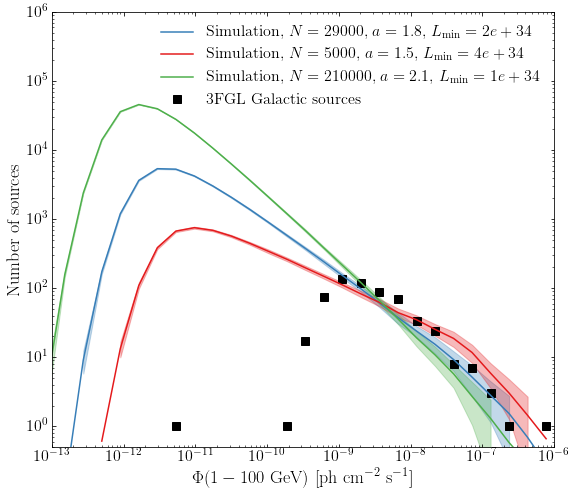

In [249]:
f,ax = plt.subplots(1,figsize=(9,8))
bins_mean = bins_3fgl_mean
hist_norm = hist_3fgl
for op in [op1,op2,op3]:
    hist_mean,hist_min,hist_max = op[0]
    options = op[4]
    hist_min = hist_min.astype('float')
    hist_min[hist_min==0]=1e-5
    N,a,Lmin = options[0:3]
    line,=ax.loglog(bins_mean,hist_mean,label=r'Simulation, $N=%s$, $a=%s$, $L_{\rm min}=%s$'%(N,a,Lmin))
    color=line.get_color()
    ax.fill_between(bins_mean,hist_min,hist_max,where=((hist_min >0)&(hist_max>0)),alpha=0.3,color=color)

    ax.set_yscale('log',nonposy='clip')
    ax.set_xlim([1e-13,1e-6])
    ax.set_ylim([5e-1,1e6])
    ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
    ax.set_ylabel(r"Number of sources",fontsize=18)
    ax.set_xlabel(r"$\Phi(1-100 \ \rm GeV) \ [\rm ph \ cm^{-2}\ s^{-1}]$",fontsize=18)
    
ax.loglog(bins_mean,hist_norm,marker='s',label='3FGL Galactic sources',ls='',ms=8,color='k',zorder=1)
ax.legend(frameon=False,loc=1,fontsize=16)
plt.savefig('hist_3mod.pdf',bbox_inches='tight')

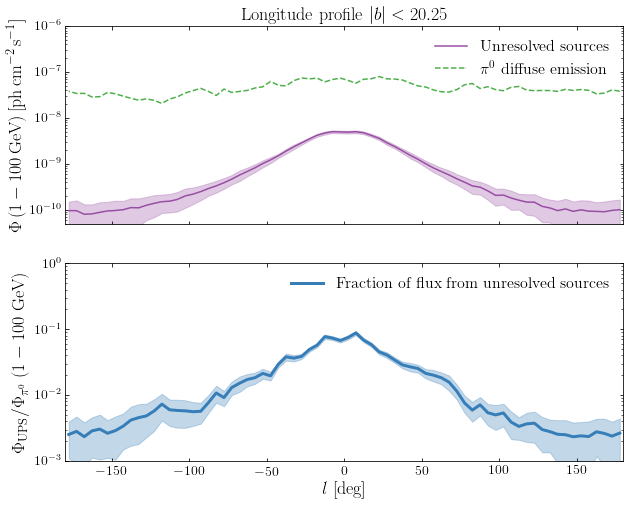

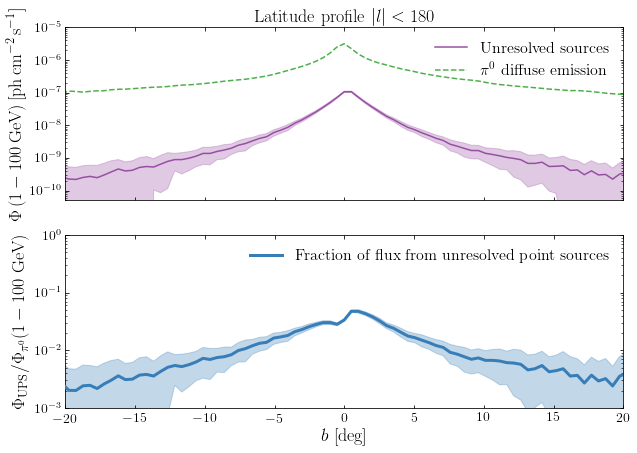

In [256]:
plot_lb_profile(op1,save=True)

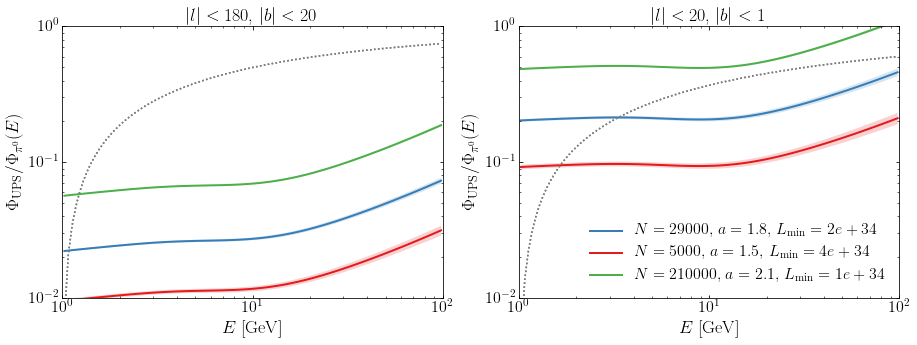

In [264]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
mpl.rcParams['axes.color_cycle'] = [c2,c6,c3,c4,c5,c1,c7,c8,c9]
for op in [op1,op2,op3]:
    "Plot fraction UPS with output ave_sim"
    fracmean,fracmin,fracmax = op[1]
    options = op[4]
    E = options[5]
    Emean = (E[1:]+E[:-1])/2.
    N,a,Lmin = options[:3]
 
    line, = ax1.loglog(Emean,fracmean[0],label=r'$N=%s$, $a=%s$, $L_{\rm min}=%s$'%(N,a,Lmin),lw=2,zorder=1)
    ax1.fill_between(Emean,fracmin[0],fracmax[0],alpha=0.2)
    ax1.set_title(r"$|l| < %s$, $|b|<%s$"%lb[0],fontsize=18)
    
    line, = ax2.loglog(Emean,fracmean[-1],label=r'$N=%s$, $a=%s$, $L_{\rm min}=%s$'%(N,a,Lmin),lw=2,zorder=1)
    ax2.fill_between(Emean,fracmin[-1],fracmax[-1],alpha=0.2)
    ax2.set_title(r"$|l| < %s$, $|b|<%s$"%lb[-1],fontsize=18)
    ax1.loglog(Emean,1-Emean**-0.3,ls=':',color='grey')
    ax2.loglog(Emean,1-Emean**-0.2,ls=':',color='grey')
    ax2.legend(frameon=False,fontsize=16,loc=0)
    for ax in [ax1,ax2]:
        ax.set_ylim([1e-2,1])
        ax.tick_params(direction='in',which='both',top='on',right='on',labelsize=16)
        ax.set_ylabel(r"$\Phi_{\rm UPS}/\Phi_{\pi^0}(E)$",fontsize=18)
        ax.set_xlabel(r"$E$ [GeV]",fontsize=18)
        
        ax.set_xlim([1,100])
        
plt.savefig('fraction_2sky_3mod.pdf',bbox_inches='tight')

# 3FHL

In [160]:
E3fhl = np.logspace(1,3,101)
E3fhl_mean = (E3fhl[1:]+E3fgl[:-1])/2.
dE_3fhl = (E3fhl[1:]-E3fhl[:-1])/2.
bins_3fhl = np.logspace(-15,-7,32)
bins_3fhl_mean = (bins_3fhl[1:]+bins_3fhl[0:-1])/2.

In [161]:
fl2 = 'gll_psch_v13.fit'
flux_3fhl,spec_3fhl = simulation.read_catalog(fl2,E3fhl_mean,classes=['pwn','spp','snr','psr','lat'])
##'lat' means take also unassociated sources with |b|<5
hist_3fhl = np.histogram(flux_3fhl,bins=bins_3fhl)[0]

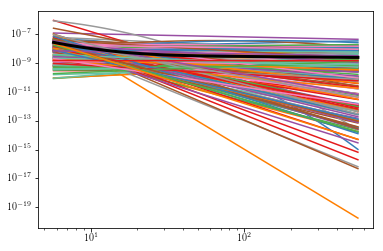

In [165]:
for sp in spec_3fhl:
    plt.loglog(E3fhl_mean,E3fhl_mean**2*sp)
    
plt.loglog(E3fhl_mean,E3fhl_mean**2*np.mean(spec_3fhl,axis=0),lw=3,color='k')

In [167]:
spec_diff_lb_3fhl = get_diffuse(E3fhl_mean)

In [168]:
op2 = ave_sim(10,[29000,1.8,2e32,1e37,1e-9,E3fhl,spec_3fhl,spec_diff_lb_3fhl,bins_3fhl])

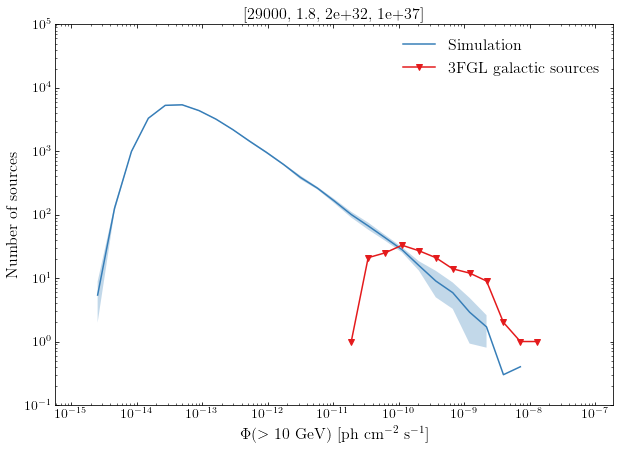

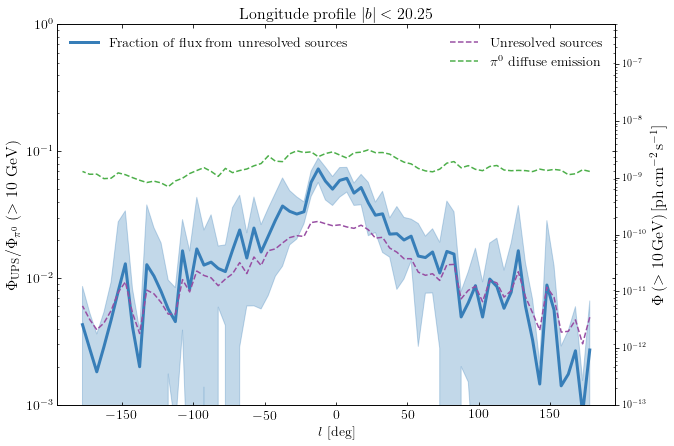

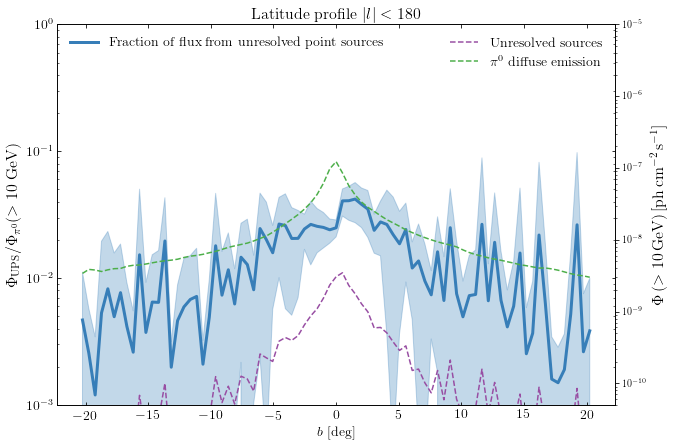

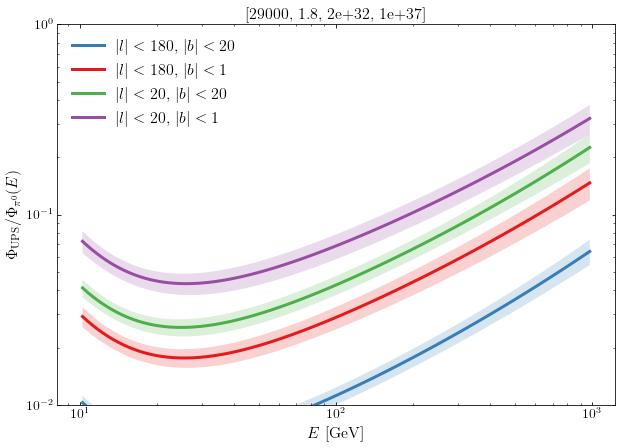

In [169]:
plot_hist(op2)
plot_lb_profile(op2)
plot_frac(op2)